# Import libraries

In [1]:
#  Libraries
import numpy as np 
import pandas as pd 
# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from bayes_opt import BayesianOptimization
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn import metrics
from sklearn import preprocessing
# Lgbm
import lightgbm as lgb
import xgboost as xgb
# Suppr warning
import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy import interp

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import gc
import os
import sys
import pystacknet
from functools import partial
from utils import *

# from mem import reduce_mem_usage

import pickle

# Load Dataset and feature selection

In [2]:
# Load Dataset and feature selection

f = open('train_ori.bin', 'rb')
train = pickle.load(f)
f.close()

f = open('test_ori.bin', 'rb')
test = pickle.load(f)
f.close()

ctd = pd.read_pickle('remove_features.pkl')

cols_to_drop = []
for f in ctd.values:
    cols_to_drop.append(list(f)[0])
    
# cols_to_drop.remove('DT_M')
# cols_to_drop.remove('DT_hour')
cols_to_drop.remove('isFraud')

print('removed cols:', cols_to_drop)

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')


removed cols: ['TransactionID', 'TransactionDT', 'DT', 'DT_W', 'DT_D', 'DT_day_week', 'DT_day_month', 'DT_M_total', 'DT_W_total', 'DT_D_total', 'uid', 'uid2', 'uid3', 'uid4', 'uid5', 'bank_type']


In [3]:
f = open('imp_col.bin', 'rb')
imp_cols = pickle.load(f)
f.close()

In [5]:
train = train[imp_cols]
imp_cols.remove('isFraud')
test = test[imp_cols]

In [9]:
# # use only for initial feature selection
# for f in train.columns:
#     if sum(pd.isna(train[f]))/len(train) > 0.9:
#         train = train.drop(f, axis=1)
#         test = test.drop(f, axis=1)
#         print(f)

In [7]:
print(train.shape)
print(test.shape)

(590540, 646)
(506691, 645)


In [6]:
# divide variable type

numerical = ["TransactionAmt", "nulls1", "dist1", "dist2"] + ["C" + str(i) for i in range(1, 15)] + \
            ["D" + str(i) for i in range(1, 16)] + \
            ["V" + str(i) for i in range(1, 340)] + ["id_0" + str(i) for i in range(1, 10)] + ["id_" + str(i) for i in range(10, 12)]

categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
               "P_emaildomain_bin", "P_emaildomain_suffix", "R_emaildomain_bin", "R_emaildomain_suffix",
               "P_emaildomain", "R_emaildomain",
              "DeviceInfo", "DeviceType"] + \
                ["id_" + str(i) for i in range(12, 39)] + \
                 ["M" + str(i) for i in range(1, 10)] +['Transaction_day_of_week', 'Transaction_hour_of_day', 'DT', 'DT_hour']

In [ ]:
# label encoding
for f in train.columns:
    if f in categorical:
        
            train[f] = train[f].replace("nan", "other")
            train[f] = train[f].replace(np.nan, "other")
            test[f] = test[f].replace("nan", "other")
            test[f] = test[f].replace(np.nan, "other")
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train[f].values) + list(test[f].values))
            train[f] = lbl.transform(list(train[f].values))
            test[f] = lbl.transform(list(test[f].values))
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train[f].values) + list(test[f].values))
            train[f] = lbl.transform(list(train[f].values))
            test[f] = lbl.transform(list(test[f].values)) 
            col.append(f)
            

In [ ]:
# if you want to downsampling or upsampling
## see details in utils.py
# train = Negativedownsampling(train, 9)
# train = train.reset_index(drop=True)

# print(train.shape)

# Bayes-opt

In [7]:
bounds_LGB = {
    'num_leaves': (300, 1000), 
    'min_data_in_leaf': (0, 150),
    'bagging_fraction' : (0.3, 0.7),
    'feature_fraction' : (0.6, 0.9),
#     'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.001, 3),   
    'reg_alpha': (0.25, 0.7), 
    'reg_lambda': (0.25, 0.7),
    'max_depth':(10, 30),
}


In [8]:
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
#               'learning_rate' : 0.03,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 12,
              'feature_fraction_seed': 12,
              'bagging_seed': 12,
              'drop_seed': 12,
              'data_random_seed': 12,
              'boosting_type': 'gdbt', ## some get better result using 'dart'
              'verbose': 1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    oof = np.zeros(len(train))
    trn_data= lgb.Dataset(train.iloc[bayesian_tr_idx][features].values, label=train.iloc[bayesian_tr_idx][target].values)
    val_data= lgb.Dataset(train.iloc[bayesian_val_idx][features].values, label=train.iloc[bayesian_val_idx][target].values)
    
    ## set clf options
    clf = lgb.train(param, trn_data,  num_boost_round=150, valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds = 50)
    
    oof[bayesian_val_idx]  = clf.predict(train.iloc[bayesian_val_idx][features].values, num_iteration=clf.best_iteration) 
    
    score = roc_auc_score(train.iloc[bayesian_val_idx][target].values, oof[bayesian_val_idx])

    return score

In [9]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=12)
features = list(train.columns)
features.remove('isFraud')
target = 'isFraud'

In [10]:
#cut tr and val
bayesian_tr_idx, bayesian_val_idx = train_test_split(train, test_size = 0.3, random_state = 19, stratify = train[target])
bayesian_tr_idx = bayesian_tr_idx.index
bayesian_val_idx = bayesian_val_idx.index

In [11]:
init_points = 10
n_iter = 15

In [12]:
gc.collect()

61

In [13]:
print('-' * 120)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9667   |  0.3617   |  0.822    |  15.27    |  1.602    |  2.186    |  759.4    |  0.6553   |  0.265    |
|  2        |  0.9611   |  0.6828   |  0.6412   |  15.68    |  1.819    |  141.6    |  726.4    |  0.251    |  0.4846   |
|  3        |  0.9574   |  0.5208   |  0.7456   |  25.36    |  0.483    |  114.7    |  310.4    |  0.3108   |  0.3023   |
|  4        |  0.9645   |  0.424    |  0.8014   |  19.42    |  2.449    |  43.44    |  666.6    |  0.5662   |  0.3974   |
|  5        |  0.9628   |  0.4339   |  0.8934   |  22.49    |  2.851    |  115.1    |  712.5    |  0.433    |  0.4531   |
|  6        |  0.9616   |

In [14]:
LGB_BO.max['target']

0.9676037042273492

In [15]:
param_lgb = {
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
        #'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': LGB_BO.max['params']['min_child_weight'],
        'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'reg_lambda': LGB_BO.max['params']['reg_lambda'],
        'reg_alpha': LGB_BO.max['params']['reg_alpha'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), 
        'objective': 'binary',
        'save_binary': True,
        'seed': 12,
        'feature_fraction_seed': 12,
        'bagging_seed': 12,
        'drop_seed': 12,
        'data_random_seed': 12,
        'boosting_type': 'gdbt',  # also consider 'dart'
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }


fold 1
[100]	training's auc: 0.993784	valid_1's auc: 0.957035
[200]	training's auc: 0.999987	valid_1's auc: 0.9706
[300]	training's auc: 1	valid_1's auc: 0.973165
[400]	training's auc: 1	valid_1's auc: 0.973642
[500]	training's auc: 1	valid_1's auc: 0.974178
[600]	training's auc: 1	valid_1's auc: 0.974052
[700]	training's auc: 1	valid_1's auc: 0.973806
[800]	training's auc: 1	valid_1's auc: 0.973646
[900]	training's auc: 1	valid_1's auc: 0.97386
[1000]	training's auc: 1	valid_1's auc: 0.973901
[1100]	training's auc: 1	valid_1's auc: 0.974071
[1200]	training's auc: 1	valid_1's auc: 0.974307
[1300]	training's auc: 1	valid_1's auc: 0.97418
[1400]	training's auc: 1	valid_1's auc: 0.974127
[1500]	training's auc: 1	valid_1's auc: 0.974116

fold 2
[100]	training's auc: 0.993243	valid_1's auc: 0.961109
[200]	training's auc: 0.999984	valid_1's auc: 0.974157
[300]	training's auc: 1	valid_1's auc: 0.976579
[400]	training's auc: 1	valid_1's auc: 0.976618
[500]	training's auc: 1	valid_1's auc: 0.9

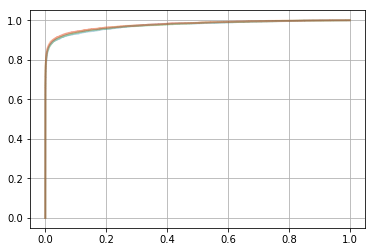

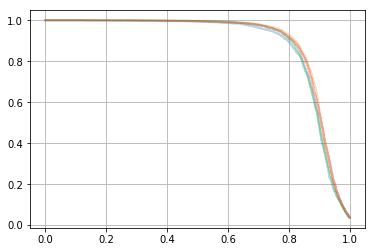

In [16]:
plt.rcParams["axes.grid"] = True

nfold = 4
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()
n_estimator = 0


bayes = np.zeros(len(train))

i = 1
for train_idx, valid_idx in skf.split(train, train.isFraud.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(train.iloc[train_idx][features].values,
                                   label=train.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(train.iloc[valid_idx][features].values,
                                   label=train.iloc[valid_idx][target].values
                                   )   
    ## clf setting
    clf = lgb.train(param_lgb, trn_data, num_boost_round = 150, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test[features]) / nfold
    bayes += clf.predict(train[features]) / nfold
    
    # Scores 
    roc_aucs.append(roc_auc_score(train.iloc[valid_idx][target].values, oof[valid_idx]))
    accuracies.append(accuracy_score(train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

### below is for visualization
# #ROC 
# f = plt.figure(1)
# plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
# mean_tpr = np.mean(tprs, axis=0)
# mean_auc = auc(mean_fpr, mean_tpr)
# plt.plot(mean_fpr, mean_tpr, color='blue',
#          label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('LGB ROC curve by folds')
# plt.legend(loc="lower right")

# # PR plt
# g = plt.figure(2)
# plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
# y_real = np.concatenate(y_real)
# y_proba = np.concatenate(y_proba)
# precision, recall, _ = precision_recall_curve(y_real, y_proba)
# plt.plot(recall, precision, color='blue',
#          label=r'Mean P|R')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('P|R curve by folds')
# plt.legend(loc="lower left")

# # Confusion maxtrix & metrics
# plt.rcParams["axes.grid"] = False
# cm = np.average(cms, axis=0)
# class_names = [0,1]
# plt.figure()
# plot_confusion_matrix(cm, 
#                       classes=class_names, 
#                       title= 'LGB Confusion matrix [averaged/folds]')
# plt.show()

In [17]:
sample_submission['isFraud'] = predictions
sample_submission.to_csv('preds/bayes_lgb.csv')

In [18]:
params = param_lgb

# Modeling

## prepare datset and params

In [8]:
y_train = train['isFraud'].copy()
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train
del test

In [24]:
X_train.shape

(590540, 645)

In [10]:
params

{'bagging_fraction': 0.6208557761807184,
 'bagging_seed': 12,
 'boost_from_average': True,
 'boosting_type': 'dart',
 'data_random_seed': 12,
 'drop_seed': 12,
 'feature_fraction': 0.8161334733057637,
 'feature_fraction_seed': 12,
 'is_unbalance': False,
 'max_depth': 26,
 'metric': 'auc',
 'min_child_weight': 1.1487246317328306,
 'min_data_in_leaf': 1,
 'num_leaves': 799,
 'objective': 'binary',
 'reg_alpha': 0.2759381261875936,
 'reg_lambda': 0.5598769107896939,
 'save_binary': True,
 'seed': 12,
 'verbose': 1}

In [11]:
## for fold options - KFold or GroupKFold
from sklearn.model_selection import TimeSeriesSplit,KFold, GroupKFold
n_fold = 5
folds = KFold(n_splits=n_fold,shuffle=True)
# folds = GroupKFold(n_splits=n_fold)
# split_gruops = train['DT_M']

print(folds)

GroupKFold(n_splits=5)


## LGBM

In [20]:
gc.collect()
lgb_submission=sample_submission.copy()
lgb_submission['isFraud'] = 0
lgb_tr = np.zeros(len(train))
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train)):
#    replace for groupkfold: folds.split(X_train, y_train, groups=split_gruops)
    print(fold_n)
    
    X_train_, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train_, y_valid = train.iloc[train_index], train.iloc[valid_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    lgbclf = lgb.LGBMClassifier(
                        **params,
                        n_estimators=500
    )
    
    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    lgbclf.fit(X_train_,y_train_)
    
    del X_train_,y_train_
    print('finish train')
    pred=lgbclf.predict_proba(X_test)[:,1]
    lgb_tr += lgbclf.predict_proba(X_train)[:,1]/n_fold
    val=lgbclf.predict_proba(X_valid)[:,1]
    print('finish pred')  
    if n_fold != 3:
        del lgbclf
    del X_valid
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    del val,y_valid
    lgb_submission['isFraud'] = lgb_submission['isFraud']+pred/n_fold
    del pred
    gc.collect()
    
lgb_submission.to_csv('preds/lgb_submission.csv')

0
finish train
finish pred
ROC accuracy: 0.9070130465760226
1
finish train
finish pred
ROC accuracy: 0.9447442576724936
2
finish train
finish pred
ROC accuracy: 0.9430777885480857
3
finish train
finish pred
ROC accuracy: 0.9389094823261478
4
finish train
finish pred
ROC accuracy: 0.9509038568646326


In [8]:
f = open('params.bin', 'rb')
params = pickle.load(f)
f.close()

In [28]:
params

{'bagging_fraction': 0.6208557761807184,
 'bagging_seed': 12,
 'boost_from_average': True,
 'boosting_type': 'dart',
 'data_random_seed': 12,
 'drop_seed': 12,
 'feature_fraction': 0.8161334733057637,
 'feature_fraction_seed': 12,
 'is_unbalance': False,
 'max_depth': 26,
 'metric': 'auc',
 'min_child_weight': 1.1487246317328306,
 'min_data_in_leaf': 1,
 'num_leaves': 799,
 'objective': 'binary',
 'reg_alpha': 0.2759381261875936,
 'reg_lambda': 0.5598769107896939,
 'save_binary': True,
 'seed': 12,
 'verbose': 1}

## XGBOOST

In [12]:
# parmas for xgboost
params_fx = {'min_data_in_leaf': params['min_data_in_leaf'],
 'num_leaves': params['num_leaves'],
 'min_child_weight': params['min_child_weight'],
 'bagging_fraction': params['bagging_fraction'],
 'feature_fraction': params['feature_fraction'],
 'reg_lambda': params['reg_lambda'],
 'reg_alpha': params['reg_alpha'],
 'max_depth': params['max_depth'],

}

gc.collect()

11

In [13]:
params_fx

{'bagging_fraction': 0.6208557761807184,
 'feature_fraction': 0.8161334733057637,
 'max_depth': 26,
 'min_child_weight': 1.1487246317328306,
 'min_data_in_leaf': 1,
 'num_leaves': 799,
 'reg_alpha': 0.2759381261875936,
 'reg_lambda': 0.5598769107896939}

In [19]:
gc.collect()
xgb_submission=sample_submission.copy()

xgb_submission['isFraud'] = 0
xgb_tr = np.zeros(len(train))
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from sklearn.metrics import roc_auc_score

for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train)):
    #    replace for groupkfold: folds.split(X_train, y_train, groups=split_gruops)
    print(fold_n)
    xgbclf = xgb.XGBClassifier(
            **params_fx,
#             n_estimators=500,
            tree_method = 'gpu_hist'
    )
    
    X_train_, X_valid = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
    xgbclf.fit(X_train_,y_train_)
    del X_train_,y_train_
    pred=xgbclf.predict_proba(X_test)[:,1]
    xgb_tr+=xgbclf.predict_proba(X_train)[:,1]/n_fold
    val=xgbclf.predict_proba(X_valid)[:,1]
    if fold_n != 3:
        del xgbclf
    del X_valid
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    del val,y_valid
    xgb_submission['isFraud'] = xgb_submission['isFraud']+pred/n_fold
    del pred
    gc.collect()
    
xgb_submission.to_csv('preds/xgb_submission.csv')

0
ROC accuracy: 0.9052945832066803
1
ROC accuracy: 0.941635351643685
2
ROC accuracy: 0.9381577110140165
3
ROC accuracy: 0.9364709408817641
4
ROC accuracy: 0.9470379147664763


In [22]:
gc.collect()

0

## STACKING and ENSEMBLE

In [25]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

lgbclf = lgb.LGBMRegressor(**params,
                          n_estimators=500)

xgbclf = xgb.XGBRegressor(
            **params_fx,
            n_estimators=500,
            tree_method = 'hist'
    )

rfclf = RandomForestRegressor(n_estimators=150,
                              max_depth=9, 
                                max_features='sqrt', 
                                random_state=12)

In [26]:
models = [[lgbclf, xgbclf], # Level 1
          [rfclf]] # Level 2

In [ ]:
## for calculation error
# X_train=X_train.replace(np.inf,-999)
# X_train=X_train.replace(-np.inf,-999)
# X_test=X_test.replace(np.inf,-999)
# X_test=X_test.replace(-np.inf,-999)

In [ ]:
from pystacknet.pystacknet import StackNetClassifier

# Specify parameters for stacked model and begin training
model = StackNetClassifier(models, 
                           metric="auc", 
                           folds=4,
                           restacking=False,
                           use_retraining=True,
                           use_proba=True, # To use predict_proba after training
                           random_state=12,
                           n_jobs=-1, 
                           verbose=1)

model.fit(X_train.values, y_train.values)

====================== Start of Level 0 ======================
Input Dimensionality 645 at Level 0 
2 models included in Level 0 


In [ ]:
stack_submission = sample_submission.copy()
preds = model.predict_proba(X_test.values)[:, 1]
stack = model.predict_proba(X_train.values)[:,1]
stack_submission['isFraud'] = preds

In [ ]:
## for ensemble parameter use this with nn or something

# meaning_set = pd.DataFrame()

# meaning_set['m1'] = lgb_tr
# meaning_set['m2'] = xgb_tr
# meaning_set['m3'] = stack
# # meaning_set['m4'] = lgb_tr

# y_mean = y_train

In [ ]:
ensemble=sample_submission.copy()
ensemble.isFraud=lgb_submission*0.4+xgb_submission*0.2+stack_submission*0.4
#ensemble.isFraud=lgb_submission*0.5+xgb_submission*0.5

ensemble.to_csv('preds/xgb_lgb_stacking.csv')
lgb_submission.to_csv('preds/lgb_submission.csv')
xgb_submission.to_csv('preds/xgb_submission.csv')
stack_submission.to_csv('preds/ens_submission.csv')

# Update feature

In [44]:
import xgboost as xgb
import lightgbm as lgb

lgbclf = lgb.LGBMClassifier(
    **params,
    n_estimator = 200,
)
    
lgbclf.fit(X_train, y_train)

lgb_imp = lgbclf.feature_importances_

lgb_imp_idx = []
cols = X_train.columns
for i, imp in enumerate(lgb_imp):
    if imp > 0:
        lgb_imp_idx.append(i)
        
new_cols_imp = cols[lgb_imp_idx]

# print(len(cols_imp)  ,len(new_cols_imp))

In [45]:
new_cols_imp = list(new_cols_imp)
new_cols_imp.append('isFraud')

In [46]:
print(len(train.columns), len(new_cols_imp))

645 643


In [ ]:
f = open('new_cols.bin', 'wb')
pickle.dump(f, new_cols_imp)
f.close()